### imports and plot function

In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

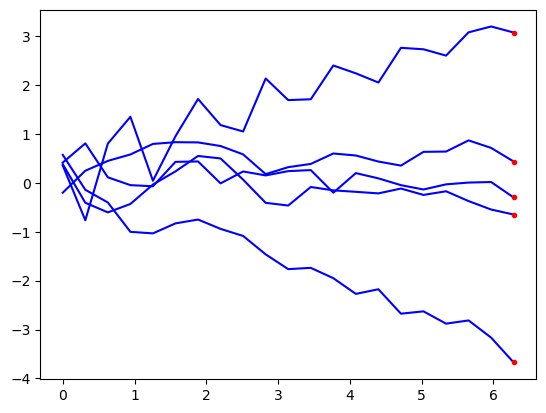

In [16]:
# create example data
def create_example_data(batch_size, seq_length,
                        input_size, device, horizon=1, trend=False):
    # Generate random frequencies and phases (0, 10) (0, 2*pi)
    frequencies = torch.rand(batch_size) * 10  
    phases = torch.rand(batch_size) * 2 * math.pi  
    
    damping = torch.rand(batch_size)

    # Create a time vector (+ target)
    time = torch.linspace(0, 2 * math.pi, seq_length + horizon)

    # Generate sine waves (+ target)
    sine_waves = torch.zeros(batch_size, seq_length + horizon)
    for i in range(batch_size):
        sine_waves[i] = (np.exp(-damping[i] * time) *
            torch.sin(frequencies[i] * time + phases[i]))
    
    if trend:
        for i in range(batch_size):
            end_point = 8 * torch.rand(1)[0]  - 4
            sine_waves[i] += torch.linspace(0, end_point, seq_length + horizon)
                
    
    # add additive amplitude noise to features
    sine_waves[:, :-horizon] +=  torch.rand(batch_size, seq_length) / 2
    
    # Split into inputs and targets
    sine_waves = sine_waves[:, :, None]
    inputs = sine_waves[:, :-horizon].to(device)
    if horizon > 1:
        targets = sine_waves[:, -horizon:].to(device)
    else:
        targets = sine_waves[:, -1].unsqueeze(-1).to(device)
  
    return sine_waves, inputs, targets, time

# Generate example data
sine_waves, example_input, example_target, time = create_example_data(
    32,
    20,
    1,
    DEVICE,
    trend=True)

# plot example data
plt.figure()

for i in np.random.randint(0, len(example_input), 5):
    plt.plot(
        time,
        sine_waves[i].squeeze().cpu().detach().numpy(),
        'b-')
    plt.plot(
        time[-1],
        sine_waves[i][-1].squeeze().cpu().detach().numpy(),
        'r.')
plt.show()

# Basic N-Beats Network

In [17]:
class NBeatsBlock(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        theta_size,
        num_layers,
        block_type,
    ):
        super(NBeatsBlock, self).__init__()
        
        self.block_type = block_type
        
        # fully connected layers
        self.fc = nn.ModuleList(
            [nn.Linear(input_size, hidden_size)] + 
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers-1)]
        )
        self.activations = nn.ModuleList(
            [nn.ReLU() for _ in range(num_layers)]
        )
        
        # theta output layer
        self.theta_fc = nn.Linear(
            hidden_size, theta_size
        )
        
        # basic expansion layers
        match block_type:
            case "trend":
                self.backcast_fc = nn.Linear(
                    theta_size, input_size
                )
                self.forecast_fc = nn.Linear(
                    theta_size, output_size
                )
            case "seasonality":
                self.backcast_fc = nn.Linear(
                    theta_size, input_size
                )
                self.forecast_fc = nn.Linear(
                    theta_size, output_size
                )
            case _:
                raise ValueError(
                    f"Unsupported block type: {block_type}"
                )
        
    def forward(
        self,
        x: torch.Tensor
    ) -> torch.Tensor:
        
        # fully connected layers
        for fc, act in zip(self.fc, self.activations):
            x = act(fc(x))
        
        # compute theta
        theta = self.theta_fc(x)
        theta = F.sigmoid(theta)  # theta in [0, 1]
        
        # compute backcast and forecast
        backcast = self.backcast_fc(theta)
        forecast = self.forecast_fc(theta)
        
        return backcast, forecast


class NBeats(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        num_blocks,
        hidden_size,
        num_layers,
    ):
        super(NBeats, self).__init__()
        
        self.blocks = nn.ModuleList()
        
        for i in range(num_blocks):
            block_type = ("trend"
                          if i % 2 == 0
                          else "seasonality")
            theta_size = (output_size * 2
                          if block_type == 'trend'
                          else output_size)
            self.blocks.append(
                NBeatsBlock(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    output_size=output_size,
                    theta_size=theta_size,
                    num_layers=num_layers,
                    block_type=block_type,
                )
            )
        self.output_size = output_size
            
    def forward(
        self, 
        x: torch.Tensor
    ) -> torch.Tensor:
        
        backcast = x
        forecast = torch.zeros(
            x.size(0),
            self.output_size,
            device=x.device
        )
        
        for block in self.blocks:
            block_backcast, block_forecast = block(backcast)
            
            backcast = backcast - block_backcast
            forecast = forecast + block_forecast
        
        return forecast

### Test the network

In [18]:
# Parameters
sequence_length = 30   # Input sequence length
input_size = 1
output_size = 1  # Forecast horizon
num_blocks = 4    # Number of N-BEATS blocks
hidden_size = 256 # Hidden layer size
num_layers = 4    # Layers per block
num_periods = 4   # Number of seasonalities

# Model
model = NBeats(
    input_size=sequence_length,
    output_size=output_size, 
    num_blocks=num_blocks,
    hidden_size=hidden_size,
    num_layers=num_layers
).to(DEVICE)

print(model)

# Dummy data
batch_size = 16
x = torch.randn(batch_size, sequence_length, device=DEVICE)

# Forward pass
y = model(x)
print("Input shape:", x.shape)
print("Output shape:", y.shape)

NBeats(
  (blocks): ModuleList(
    (0): NBeatsBlock(
      (fc): ModuleList(
        (0): Linear(in_features=30, out_features=256, bias=True)
        (1-3): 3 x Linear(in_features=256, out_features=256, bias=True)
      )
      (activations): ModuleList(
        (0-3): 4 x ReLU()
      )
      (theta_fc): Linear(in_features=256, out_features=2, bias=True)
      (backcast_fc): Linear(in_features=2, out_features=30, bias=True)
      (forecast_fc): Linear(in_features=2, out_features=1, bias=True)
    )
    (1): NBeatsBlock(
      (fc): ModuleList(
        (0): Linear(in_features=30, out_features=256, bias=True)
        (1-3): 3 x Linear(in_features=256, out_features=256, bias=True)
      )
      (activations): ModuleList(
        (0-3): 4 x ReLU()
      )
      (theta_fc): Linear(in_features=256, out_features=1, bias=True)
      (backcast_fc): Linear(in_features=1, out_features=30, bias=True)
      (forecast_fc): Linear(in_features=1, out_features=1, bias=True)
    )
    (2): NBeatsBlock

### Train the network

In [19]:
# Generate example data
sine_waves, example_input, example_target, time = create_example_data(
    batch_size,
    sequence_length,
    input_size,
    DEVICE,
    trend=True)

print(example_input.shape, example_target.shape, time.shape)

torch.Size([16, 30, 1]) torch.Size([16, 1, 1]) torch.Size([31])


In [20]:
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

example_input = example_input.squeeze(-1)
example_target = example_target.squeeze(-1)

num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(example_input)
    
    loss = criterion(output, example_target)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch: {epoch+1:4}, Loss: {loss.item():.4f}")

Epoch:  200, Loss: 3.3576
Epoch:  400, Loss: 2.3375
Epoch:  600, Loss: 1.6447
Epoch:  800, Loss: 1.1514
Epoch: 1000, Loss: 0.8124


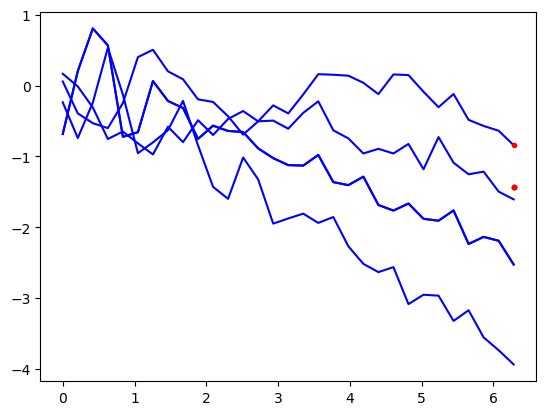

In [21]:
# plot example data
plt.figure()
for i in np.random.randint(0, len(example_input), 5):
    plt.plot(
        time,
        sine_waves[i].squeeze().cpu().detach().numpy(),
        'b-')
    plt.plot(
        time[-1],
        output[i][-1].squeeze().cpu().detach().numpy(),
        'r.')
plt.show()

# Multi Seasonality N-Beats
warning: input len == output len

In [22]:
class MultiSeasonalityBlock(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        theta_size,
        num_layers,
        num_periods,
    ):
        super(MultiSeasonalityBlock, self).__init__()
        
        self.num_periods = num_periods
        
        # fully connected layers for feature extraction
        self.fc = nn.ModuleList(
            [nn.Linear(input_size, hidden_size)] + 
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers-1)]
        )
        self.activations = nn.ModuleList(
            [nn.ReLU() for _ in range(num_layers)]
        )
        
        # trend inference network
        self.trend_fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, theta_size)
        )
        
        # multiple seasonalities
        self.seasonality_fcs = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, theta_size)
                ) for _ in range(self.num_periods)
             ]
        )
        
    def forward(self, x):
        for fc, act in zip(self.fc, self.activations):
            x = act(fc(x))
        
        trend = self.trend_fc(x)
        
        seasonality = torch.stack(
            [fc(x) for fc in self.seasonality_fcs], dim=1
        )
        
        total_seasonality = torch.sum(seasonality, dim=1)

        
        forecast = trend + total_seasonality
        
        return forecast, total_seasonality, trend


class NBeatsExt(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        num_blocks,
        hidden_size,
        num_layers,
        num_periods,
    ):
        super(NBeatsExt, self).__init__()
        
        self.blocks = nn.ModuleList()
        
        for i in range(num_blocks):
            self.blocks.append(
                MultiSeasonalityBlock(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    theta_size=output_size,
                    num_layers=num_layers,
                    num_periods=num_periods,
                )
            )
        
        self.output_size = output_size
        
    def forward(self, x):
        residual = x
        forecast = torch.zeros(
            x.size(0),
            self.output_size,
            device=x.device,
            requires_grad=True
        )
        
        
        
        for block in self.blocks:
            block_forecast, season, trend = block(residual)
            
            residual = residual - block_forecast
            forecast = forecast + block_forecast
            
            
        
        return forecast, season, trend
            

In [23]:
# Parameters
sequence_length = 30   # Input sequence length
input_size = 1
output_size = 1  # Forecast horizon
num_blocks = 4    # Number of N-BEATS blocks
hidden_size = 256 # Hidden layer size
num_layers = 4    # Layers per block
num_periods = 4   # Number of seasonalities
batch_size = 16

model = NBeatsExt(
    input_size=sequence_length,
    output_size=output_size, 
    num_blocks=num_blocks,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_periods=num_periods
).to(DEVICE)

# Dummy data
x = torch.randn(batch_size, sequence_length, device=DEVICE)

# Forward pass
y, _, _ = model(x)
print("Input shape:", x.shape)
print("Output shape:", y.shape)


Input shape: torch.Size([16, 30])
Output shape: torch.Size([16, 1])


In [24]:
# Generate example data
sine_waves, example_input, example_target, time = create_example_data(
    batch_size,
    sequence_length,
    input_size,
    DEVICE,
    horizon=1,
    trend=True)

print(example_input.shape, example_target.shape, time.shape)

torch.Size([16, 30, 1]) torch.Size([16, 1, 1]) torch.Size([31])


In [25]:
model = NBeatsExt(
    input_size=sequence_length,
    output_size=example_target.shape[1], 
    num_blocks=num_blocks,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_periods=num_periods
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

example_input = example_input.squeeze(-1)
example_target = example_target.squeeze(-1)

num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    output, season, trend = model(example_input)
    
    loss = criterion(output, example_target)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch: {epoch+1:4}, Loss: {loss.item():.8f}")

Epoch:   20, Loss: 0.03092611
Epoch:   40, Loss: 0.00177628
Epoch:   60, Loss: 0.00006018
Epoch:   80, Loss: 0.00001162
Epoch:  100, Loss: 0.00000129
Epoch:  120, Loss: 0.00000026
Epoch:  140, Loss: 0.00000008
Epoch:  160, Loss: 0.00000001
Epoch:  180, Loss: 0.00000708
Epoch:  200, Loss: 0.00075497


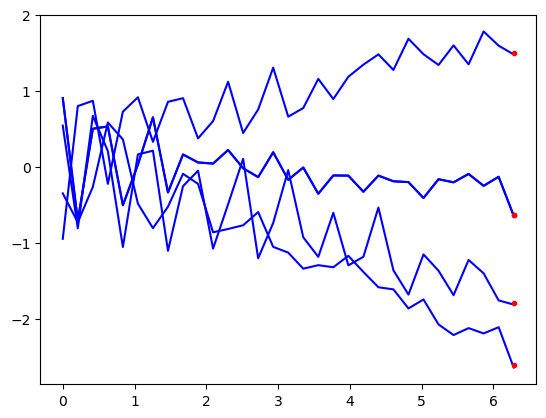

In [26]:
# plot example data
plt.figure()
for i in np.random.randint(0, len(example_input), 5):
    plt.plot(
        time,
        sine_waves[i].squeeze().cpu().detach().numpy(),
        'b-')
    plt.plot(
        time[-1],
        output[i][-1].squeeze().cpu().detach().numpy(),
        'r.')
plt.show()


In [27]:
# Generate example data
sine_waves, example_input, example_target, time = create_example_data(
    batch_size,
    sequence_length,
    input_size,
    DEVICE,
    horizon=30,
    trend=True)

print(example_input.shape, example_target.shape, time.shape)

torch.Size([16, 30, 1]) torch.Size([16, 30, 1]) torch.Size([60])


In [28]:
model = NBeatsExt(
    input_size=sequence_length,
    output_size=example_target.shape[1], 
    num_blocks=num_blocks,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_periods=num_periods
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

example_input = example_input.squeeze(-1)
example_target = example_target.squeeze(-1)

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    output, season, trend = model(example_input)
    
    loss = criterion(output, example_target)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch: {epoch+1:4}, Loss: {loss.item():.8f}")

Epoch:   20, Loss: 0.15730731
Epoch:   40, Loss: 0.03445121
Epoch:   60, Loss: 0.01265999
Epoch:   80, Loss: 0.00296090
Epoch:  100, Loss: 0.00085776


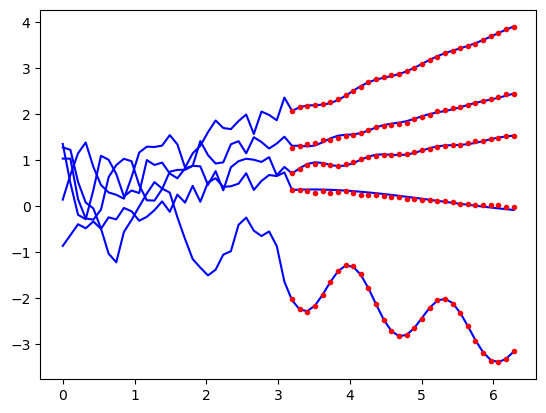

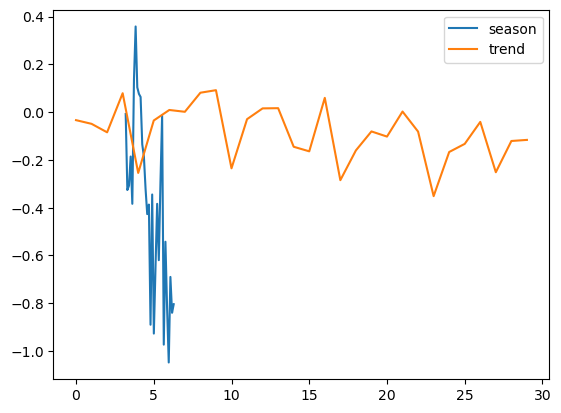

In [29]:
# plot example data
plt.figure()
for i in np.random.randint(0, len(example_input), 5):
    plt.plot(
        time,
        sine_waves[i].squeeze().cpu().detach().numpy(),
        'b-')
    plt.plot(
        time[sequence_length:],
        output[i].squeeze().cpu().detach().numpy(),
        'r.')
plt.show()


plt.figure()
plt.plot(
    time[sequence_length:],
    season[i].squeeze().cpu().detach().numpy(),
    trend[i].squeeze().cpu().detach().numpy(),
)
plt.legend(["season", "trend"])

plt.show()

# Multi Seasonality N-Beats IMP 

In [30]:
class MultiSeasonalityBlock(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        num_layers,
        num_periods,
    ):
        super(MultiSeasonalityBlock, self).__init__()
        
        self.num_periods = num_periods
        
        # fully connected layers for feature extraction
        self.fc = nn.ModuleList(
            [nn.Linear(input_size, hidden_size)] + 
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers-1)]
        )
        self.activations = nn.ModuleList(
            [nn.ReLU() for _ in range(num_layers)]
        )
        
        # trend inference network
        self.trend_fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
        # multiple seasonalities
        self.seasonality_fcs = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, output_size)
                ) for _ in range(self.num_periods)
             ]
        )
        
    def forward(self, x):
        for fc, act in zip(self.fc, self.activations):
            x = act(fc(x))
        
        trend = self.trend_fc(x)
        
        seasonality = torch.stack(
            [fc(x) for fc in self.seasonality_fcs], dim=1
        )
        
        total_seasonality = torch.sum(seasonality, dim=1)
        
        forecast = trend + total_seasonality
        
        return forecast, total_seasonality, trend


class NBeatsExt(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        num_blocks,
        hidden_size,
        num_layers,
        num_periods,
    ):
        super(NBeatsExt, self).__init__()
        
        self.blocks = nn.ModuleList()
        
        for i in range(num_blocks):
            self.blocks.append(
                MultiSeasonalityBlock(
                    input_size=output_size,
                    hidden_size=hidden_size,
                    output_size=output_size,
                    num_layers=num_layers,
                    num_periods=num_periods,
                )
            )
        
        self.output_size = output_size
        
        self.theta_res = nn.Linear(
            input_size,
            output_size
        )

        
    def forward(self, x):
        # residual = x
        
        residual = self.theta_res(x)
        
        forecast = torch.zeros(
            x.size(0),
            self.output_size,
            device=x.device,
            requires_grad=True
        )
        
        
        
        for block in self.blocks:
            block_forecast, season, trend = block(residual)
            
            residual = residual - block_forecast
            forecast = forecast + block_forecast
            
            
        
        return forecast, season, trend
            

In [31]:
# Parameters
sequence_length = 50   # Input sequence length
input_size = 1
output_size = 1  # Forecast horizon
num_blocks = 4    # Number of N-BEATS blocks
hidden_size = 256 # Hidden layer size
num_layers = 4    # Layers per block
num_periods = 3   # Number of seasonalities
batch_size = 64

# Generate example data
sine_waves, example_input, example_target, time = create_example_data(
    batch_size,
    sequence_length,
    input_size,
    DEVICE,
    horizon=100,
    trend=True)

print(example_input.shape, example_target.shape, time.shape)

torch.Size([64, 50, 1]) torch.Size([64, 100, 1]) torch.Size([150])


In [32]:
model = NBeatsExt(
    input_size=sequence_length,
    output_size=example_target.shape[1], 
    num_blocks=num_blocks,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_periods=num_periods
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

example_input = example_input.squeeze(-1)
example_target = example_target.squeeze(-1)

num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    output, season, trend = model(example_input)
    
    loss = criterion(output, example_target)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch: {epoch+1:4}, Loss: {loss.item():.8f}")

Epoch:   50, Loss: 0.16810410
Epoch:  100, Loss: 0.05261685
Epoch:  150, Loss: 0.02939928
Epoch:  200, Loss: 0.01956663
Epoch:  250, Loss: 0.01156834
Epoch:  300, Loss: 0.00534087
Epoch:  350, Loss: 0.00213220
Epoch:  400, Loss: 0.00121925
Epoch:  450, Loss: 0.00067648
Epoch:  500, Loss: 0.00034264
Epoch:  550, Loss: 0.00033072
Epoch:  600, Loss: 0.00018425


In [33]:
print(season.shape, trend.shape)

torch.Size([64, 100]) torch.Size([64, 100])


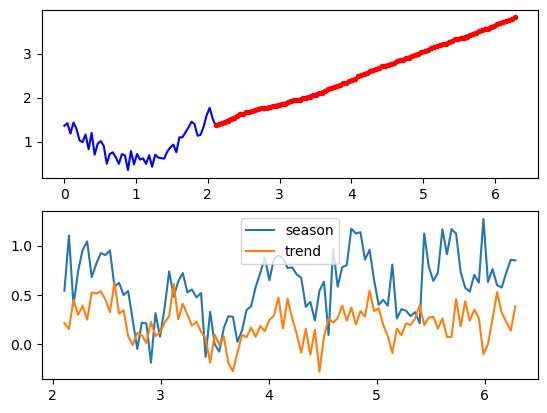

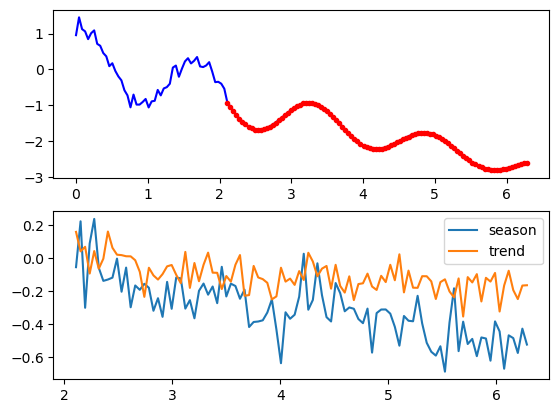

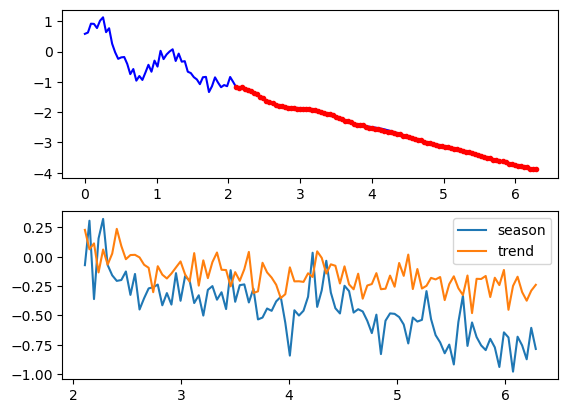

In [34]:
# plot example data
for i in np.random.randint(0, len(example_input), 3):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(
        time,
        sine_waves[i].squeeze().cpu().detach().numpy(),
        'b-')
    ax[0].plot(
        time[sequence_length:],
        output[i].squeeze().cpu().detach().numpy(),
        'r.')



    ax[1].plot(
        time[sequence_length:],
        season[i].squeeze().cpu().detach().numpy(),
    )
    ax[1].plot(
        time[sequence_length:],
        trend[i].squeeze().cpu().detach().numpy(),
    )
    plt.legend(["season", "trend"])

    plt.show()

# N-BEATS MULTI WIP

In [84]:
class MultiSeasonalityBlock(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        num_layers,
        num_periods,
    ):
        super(MultiSeasonalityBlock, self).__init__()
        
        self.num_periods = num_periods
        
        # fully connected layers for feature extraction
        self.fc = nn.ModuleList(
            [nn.Linear(input_size, hidden_size)] + 
            [nn.Linear(hidden_size, hidden_size) for _ in range(num_layers-1)]
        )
        self.activations = nn.ModuleList(
            [nn.ReLU() for _ in range(num_layers)]
        )
        
        # trend inference network
        self.trend_block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            # nn.Linear(hidden_size, output_size)
        )
        
        self.trend_bc = nn.Linear(hidden_size, input_size)
        
        self.trend_fc = nn.Linear(hidden_size, output_size)
        
        # multiple seasonalities
        self.seasonality_blocks = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                # nn.Linear(hidden_size, output_size)
                ) for _ in range(self.num_periods)
             ]
        )
        
        self.seasonality_bcs = nn.ModuleList(
            [nn.Linear(hidden_size, input_size) for _ in range(self.num_periods)]
        )
        
        
        self.seasonality_fcs = nn.ModuleList(
            [nn.Linear(hidden_size, output_size) for _ in range(self.num_periods)]
        )
        
    def forward(self, x):
        for fc, act in zip(self.fc, self.activations):
            x = act(fc(x))
        
        trend = self.trend_block(x)
        
        trend_backcast = self.trend_bc(trend)
        trend_forecast = self.trend_fc(trend)
        
        
        seasonality = torch.stack([sb(x) for sb in self.seasonality_blocks], dim=1)
        
        season_backcast = torch.einsum('ijk,ik->ij', seasonality, torch.stack([bc.weight for bc in self.seasonality_bcs]))
        season_forecast = torch.einsum('ijk,ik->ij', seasonality, torch.stack([fc.weight for fc in self.seasonality_fcs]))

        backcast = trend_backcast + season_backcast.sum(dim=1)
        forecast = trend_forecast + season_forecast.sum(dim=1)
        
        # seasonality = [sb(x) for sb in self.seasonality_blocks]
        
        # season_backcast = torch.stack(
        #     [bc(s) for bc, s in zip(self.seasonality_bcs, seasonality)], dim=1
        # )
        # season_forecast = torch.stack(
        #     [fc(s) for fc, s in zip(self.seasonality_fcs, seasonality)], dim=1
        # )
        
        # total_seasonality_bc = torch.sum(season_backcast, dim=1)
        # total_seasonality_fc = torch.sum(season_forecast, dim=1)
        
        # backcast = trend_backcast + total_seasonality_bc
        # forecast = trend_forecast + total_seasonality_fc
        
        return backcast, forecast


class NBeatsExt(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        num_blocks,
        hidden_size,
        num_layers,
        num_periods,
    ):
        super(NBeatsExt, self).__init__()
        
        self.blocks = nn.ModuleList()
        
        for i in range(num_blocks):
            self.blocks.append(
                MultiSeasonalityBlock(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    output_size=output_size,
                    num_layers=num_layers,
                    num_periods=num_periods,
                )
            )
        
        self.output_size = output_size
        
        # self.theta_res = nn.Linear(
        #     input_size,
        #     output_size
        # )

        
    def forward(self, x):
        residual = x
        
        # residual = self.theta_res(x)
        
        forecast = torch.zeros(
            x.size(0),
            self.output_size,
            device=x.device,
            requires_grad=True
        )
        
        for block in self.blocks:
            block_backcast, block_forecast = block(residual)
            
            residual = residual - block_backcast
            forecast = forecast + block_forecast
            
            
        
        return forecast

In [85]:
# Parameters
sequence_length = 50   # Input sequence length
input_size = 1
output_size = 1  # Forecast horizon
num_blocks = 4    # Number of N-BEATS blocks
hidden_size = 256 # Hidden layer size
num_layers = 4    # Layers per block
num_periods = 3   # Number of seasonalities
batch_size = 64

# Generate example data
sine_waves, example_input, example_target, time = create_example_data(
    batch_size,
    sequence_length,
    input_size,
    DEVICE,
    horizon=100,
    trend=True)

print(example_input.shape, example_target.shape, time.shape)

torch.Size([64, 50, 1]) torch.Size([64, 100, 1]) torch.Size([150])


In [86]:
model = NBeatsExt(
    input_size=sequence_length,
    output_size=example_target.shape[1], 
    num_blocks=num_blocks,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_periods=num_periods
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

example_input = example_input.squeeze(-1)
example_target = example_target.squeeze(-1)

num_epochs = 600

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    output = model(example_input)
    
    loss = criterion(output, example_target)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch: {epoch+1:4}, Loss: {loss.item():.8f}")

RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (3) for operand 1 and no ellipsis was given

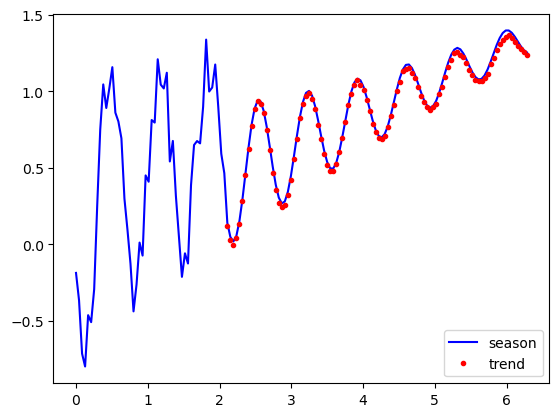

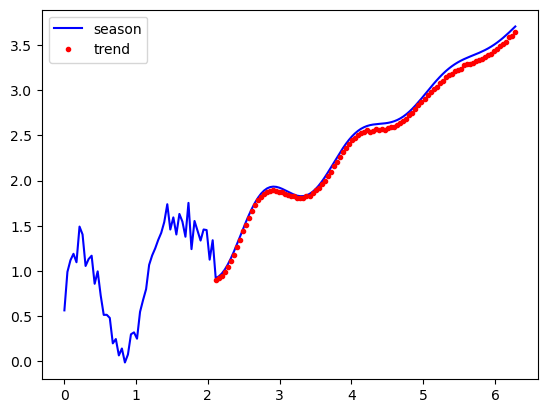

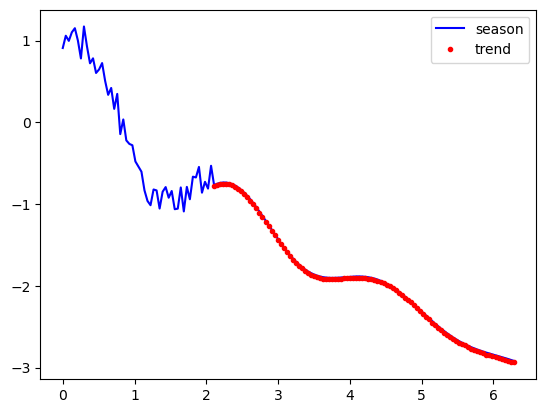

In [ ]:
# plot example data
for i in np.random.randint(0, len(example_input), 3):
    fig, ax = plt.subplots(1, 1)
    ax.plot(
        time,
        sine_waves[i].squeeze().cpu().detach().numpy(),
        'b-')
    ax.plot(
        time[sequence_length:],
        output[i].squeeze().cpu().detach().numpy(),
        'r.')

    plt.legend(["season", "trend"])

    plt.show()